###**Task 1: Import Libraries**

In [1]:
!pip install livelossplot

In [2]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
%matplotlib inline

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Input, Dropout,Flatten, Conv2D
from tensorflow.keras.layers import BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model

from IPython.display import SVG, Image
# from livelossplot import PlotLossesTensorFlowKeras
from livelossplot import PlotLossesKeras
from livelossplot.keras import PlotLossesCallback
import tensorflow as tf
print("Tensorflow version:", tf.__version__)

Tensorflow version: 2.5.0


###**Task 2: Plot Sample Images**

**Getting the data**

In [3]:
! pip install -q kaggle

In [4]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/

In [5]:
!rm /content/*.zip

rm: cannot remove '/content/*.zip': No such file or directory


In [6]:
 ! chmod 600 ~/.kaggle/kaggle.json

In [7]:
!kaggle datasets download -d msambare/fer2013 -p /content/fer_data/ --unzip

 71% 43.0M/60.3M [00:00<00:00, 155MB/s]
100% 60.3M/60.3M [00:00<00:00, 201MB/s]


**Plotting**

In [8]:
import os
from tensorflow.keras.preprocessing.image import load_img, img_to_array

def plot_example_images(plt):
    img_size = 48
    plt.figure(0, figsize=(12,20))
    ctr = 0

    for expression in os.listdir("fer_data/train/"):
        for i in range(1,6):
            ctr += 1
            plt.subplot(7,5,ctr)
            img = load_img("fer_data/train/" + expression + "/" +os.listdir("fer_data/train/" + expression)[i], target_size=(img_size, img_size))
            plt.imshow(img, cmap="gray")

    plt.tight_layout()
    return plt


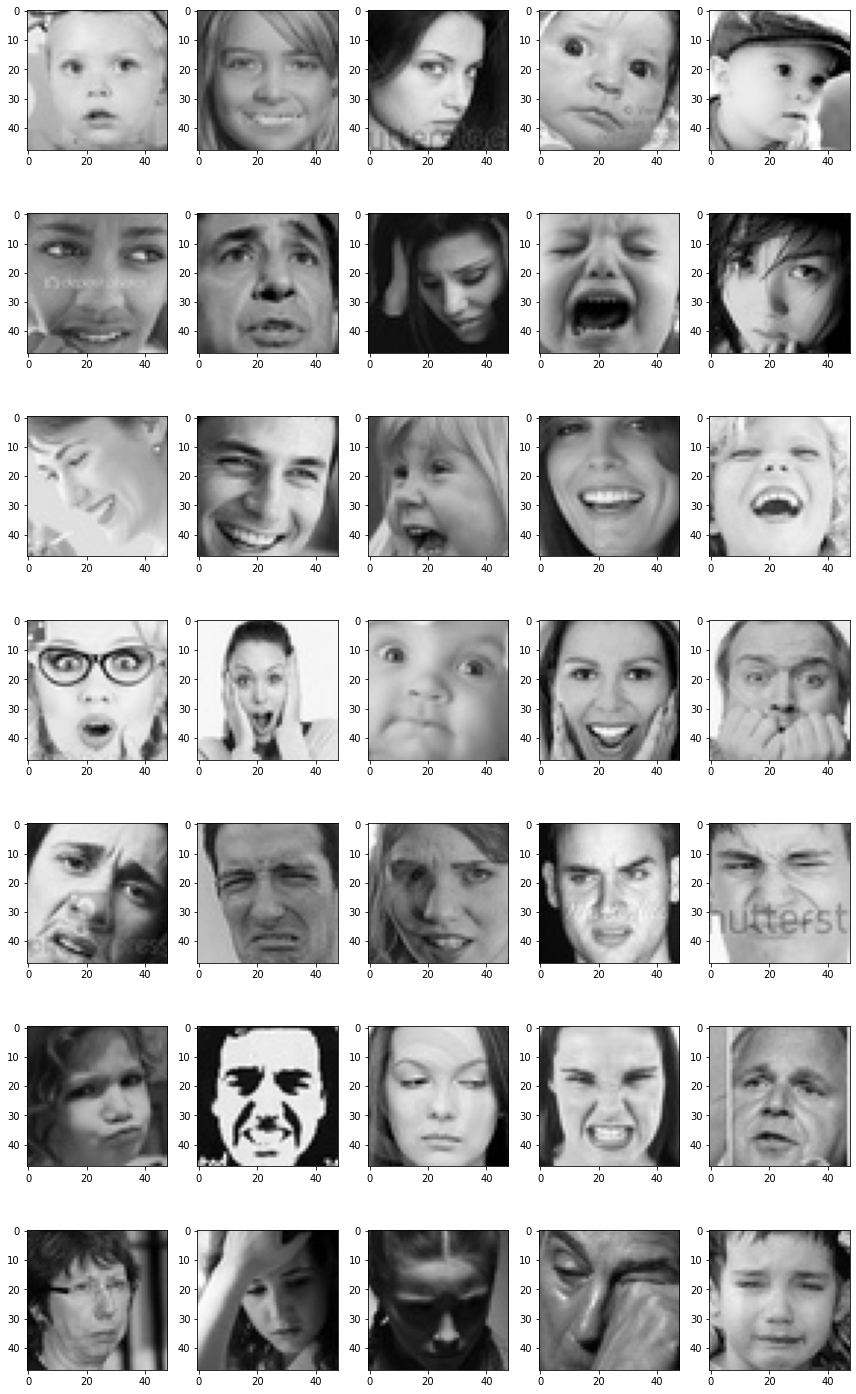

In [9]:
plot_example_images(plt).show()

In [10]:
for expression in os.listdir("fer_data/train"):
  print(str(len(os.listdir("fer_data/train/" + expression))) + " " + expression + " images")

4965 neutral images
4097 fear images
7215 happy images
3171 surprise images
436 disgust images
3995 angry images
4830 sad images


###**Task 3: Generating Training and Validation Batches**

In [11]:
img_size = 48
batch_size = 64

datagen_train = ImageDataGenerator(horizontal_flip=True)
train_generator = datagen_train.flow_from_directory("fer_data/train/", 
                                                    target_size=(img_size, img_size), 
                                                   color_mode='grayscale',
                                                   batch_size=batch_size,
                                                   class_mode='categorical',
                                                   shuffle=True)

datagen_validation = ImageDataGenerator(horizontal_flip=True)
validation_generator = datagen_validation.flow_from_directory("fer_data/test/", 
                                                    target_size=(img_size, img_size), 
                                                   color_mode='grayscale',
                                                   batch_size=batch_size,
                                                   class_mode='categorical',
                                                   shuffle=True)

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


###**Task 4: Creating CNN model**

In [12]:
model = Sequential()

# FEATURE EXTRACTION

# 1 - conv
model.add(Conv2D(64, (3, 3), padding='same', input_shape=(48, 48, 1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 2  - conv
model.add(Conv2D(128, (5, 5), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 3 - conv
model.add(Conv2D(512, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 4 - conv
model.add(Conv2D(512, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25)) #regularization

model.add(Flatten())

# CLASSIFICATION

model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(7, activation='softmax'))

opt = Adam(lr=0.0005)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 48, 48, 64)        640       
_________________________________________________________________
batch_normalization (BatchNo (None, 48, 48, 64)        256       
_________________________________________________________________
activation (Activation)      (None, 48, 48, 64)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 24, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 128)       204928    
_________________________________________________________________
batch_normalization_1 (Batch (None, 24, 24, 128)       5

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


###**Task 5: Train and Evaluate the model**

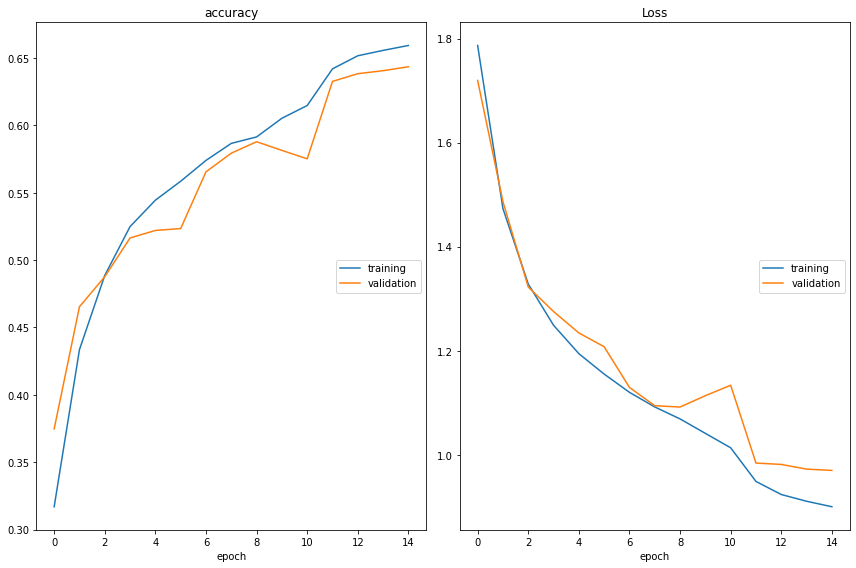

accuracy
	training         	 (min:    0.317, max:    0.659, cur:    0.659)
	validation       	 (min:    0.375, max:    0.644, cur:    0.644)
Loss
	training         	 (min:    0.900, max:    1.787, cur:    0.900)
	validation       	 (min:    0.970, max:    1.720, cur:    0.970)

Epoch 00015: saving model to model_weights.h5


In [13]:
epochs = 15
steps_per_epoch = train_generator.n//train_generator.batch_size
validation_steps = validation_generator.n//validation_generator.batch_size

checkpoint = ModelCheckpoint("model_weights.h5", monitor="val_accuracy",
                            save_weights_only=True, mode="max", verbose=1)
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=2, min_lr=0.00001, 
                             mode='auto')
callbacks = [PlotLossesCallback(), checkpoint, reduce_lr]

history = model.fit(
    x=train_generator, 
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validation_steps,
    callbacks=callbacks
)